## Welcome to the HydroShare - Python Notebook Server

You have been redirected to this page because you wish to explore, modify, and/or interact with your HydroShare resources using Python.  This notebook has been launched inside your very own userspace so that your edits can be saved for later use.  The notebook server is arranged in the following manner:

- Notebooks: (`the main directory space`)
  - Examples: (`a directory space for HydroShare related examples`)
  - Documents: (`a directory for you to create and save custom notebooks`)
  
The **examples** directory will be periodically updated to provide HydroShare users new notebook examples, which unfortunately means that anything saved here may be overwritten or lost. For this reason, we recommend that you use the **Documents** directory for you personal notebooks instead of the examples directory. 
  
The following sections outline several useful features for analysis of HydroShare resources.  Below you will find links to several notebooks that have been provided as a reference to you.  


### Terminal Commands
Any terminal commands that you have access to, can executed by prepending the command with and exclamation point (`!`).  For example, issue the following command to list the path to the current working directory `!pwd`.


### HydroShare Commands
You can interact with HydroShare resources using REST web service calls.  To help you issue these REST commands, the `hs_restclient` library ([readthedocs](http://hs-restclient.readthedocs.org/en/latest/) is installed on the system and is available for you to use.  In addition, a utility library has been provided to you, `hs_utilities`, which bundles some of useful commands into easy-to-use functions.

- Accessing HydroShare Resources
- Saving HydroShare Resources
  - Creating a new resource
  - Revising/Updating an existing resource
  - Adding new content into an existing resource

### JupyterHub Operations
The `jupyter_utils` library contains useful functions that operate on the JupyterHub environment itself.  

- Downloaded Content
    - Listing 
    - Inspecting
    - Cleaning


### Help Documentation
Help for any python library installed on the system can be obtained by issuing the `help` command.  For example, to see the documentation for the hs_utilites library, execute `help(hs_utilities)`.

---

## 1. Getting Started
To get started, lets establish a secure connection with HydroShare and retrieve the content for the resource that you launched JupyterHub with.

In [1]:
# import some libaries
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from osgeo import osr, gdal

# import hs_utils and load environment
from hs_utils import hs
hs.load_environment()

# get the data directory (this is an environment variable that is provided to you)
data_directory = os.environ['DATA']

Adding the following system variables:
   HS_USR_NAME = TonyCastronova
   HS_RES_ID = 2f0ed301f0224531a59f6256ffb913a0
   HS_RES_TYPE = rasterresource

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => TonyCastronova


In [2]:
# create a hydroshare instance
hs.getSecureConnection(username=os.environ['HS_USR_NAME'])

Enter you HydroShare Password: ········


### Retrieve a raster resource using its ID

The raster resouce id can be found by navigating to a resource in HydroShare and selecting the ID from the URL.  It is also displayed when importing the `hs_utils` library (above)

In [3]:
# get some resource content. The resource content is returned as a dictionary
content = hs.getResourceFromHydroShare(os.environ['HS_RES_ID'])

ad8.tif,/home/jovyan/work/notebooks/data/2f0ed301f0224531a59f6256ffb913a0/2f0ed301f0224531a59f6256ffb913a0/data/contents/ad8.tif


### Define a Function for Plotting TIFs

**Plot_tiff** will provide some simple plotting so that we can see the results of our TauDEM operations


In [4]:
def plot_tiff(tiff, size=(5,5), aspect=1):
    # change the aspect ration to stretch or compress the image
    
    # read the tiff using the gdal library  
    ds = gdal.Open(tiff)
    band = ds.GetRasterBand(1)
    data = band.ReadAsArray()

    # set all negative values (i.e. nodata) to zero so that the map is displayed properly
    data[data<0] = 0

    # create figure to hold plot (figsize=(width, height))
    plt.figure(figsize=size)

    # plot the DEM and display the results
    plt.imshow(data, cmap='gist_earth', aspect=aspect)
    plt.show()

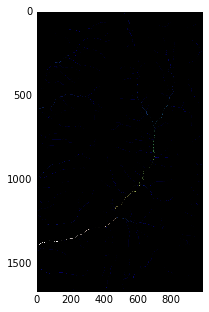

In [5]:
# plot a tif raster, if one exists within the HydroShare content
for k,v in hs.content.items():
    if k[-3:] == 'tif':
        plot_tiff(v)
        break


### Save the results back into HydroShare

Using the HydroShare rest api, you can create a new resource in HydroShare from a content file.

In [ ]:
# lets save this content as a new resource in HydroShare
abstract = 'This is a demo of the HydroShare-JupyterHub Save Function'
title = 'Hello From JupyterHub'
keywords = ['Demo', 'JupyterHub']
rtype = os.environ['HS_RES_TYPE']
files = list(hs.content.values())
resource_id = hs.createHydroShareResource(abstract, 
                                          title, 
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)